# <center>Clustering Analysis<center>

<p>Team Name: Data Dredgers
<p>Student Names: Christian Bankovic, Brian Britton, Davidson Rock

## Instructions
Use generic coding style unless hard-coded values are really necessary.<br>
Your code must be efficient and use self-explanatory naming.<br>
Use appropriate Python library methods for each task instead of using loops.<br>
Run your entire code and save. Then submit this <b>saved</b> copy.

In [170]:
import kagglehub
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
from scipy import stats
from scipy.stats import chisquare
from matplotlib import colormaps
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import random
import math
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

## Read Data

### Explanation of Columns:

`name` (`str`): Game name for parsing HowLongToBeat
- This is Steam's name for the game, and was used to compare Steam's database to HowLongToBeat's database.

`howlongtobeat` (`str`): Most similar game name found in HowLongToBeat database
- This was used when comparing Steam's database to HowLongToBeat's database.

`time_to_finish_h` (`str`): Time to finish a run
- How long, in hours, it takes to complete a single run.
- This is a string because some entries are `'No time registered yet'`.

`time_to_complete_h` (`str`): Time to complete 100% achievements
- How long, in hours, it takes to complete the game with 100% achievements.
- This is a string because some entries are `'No time registered yet'`.

`similarity` (`float`): Similarity relation between games name and the closest game in HowLongToBeat database
- This was used when comparing Steam's database to HowLongToBeat's database.

`perfect_match` (`str`): Values above 0.85 are considered perfect
- This was used when comparing Steam's database to HowLongToBeat's database.
- Values are `'Exact'`, `'Non Exact'`, or `nan`.

`name_steam_games_database` (`str`): Game as found in column 1
- This is Steam's name for the game.

`appid_steam_games` (`int`): AppID from Steam Games page
- Steam's AppID.

`appid_steam` (`float`): AppID from Steam database (may differ from previous)
- Steam's... AppID?

`name_steam_database` (`str`): Games name as it is found in Steam database
- Steam's... name for the game?

`genre` (`str`): Games genre
- The genres of each game, separated by commas.

`positive_votes` (`int`): Number of positives votes

`negative_votes` (`int`): Number of negatives votes

`developer` (`str`): Games developer

`publisher` (`str`): Games Publisher to date

`tags` (`str`): Games tags
- The tags for each game, separated by commas.

`finished` (`str`): Is it 100% completed in this user account
- Whether a game is finished or is still a WIP.
- Values here are either `nan` or `'X'`.

`played_time` (`float`): Total played time
- Is this a total value or an average value??? Probably an average, maybe.

`release` (`str`): Games release date

`minimun_requirements` (`str`): PC minimun requierements
- The person typing this doesn't know how to spell, lol.

`recommended_requirements` (`str`): PC recommended requierements
- The person typing this doesn't know how to spell, lol.

`removed_game` (`str`): Is it removed from Steam store
- Values here are either `nan` or `'X'`.

`positive_rating` (`float`): Percetage of positive votes
- The person typing this doesn't know how to spell, lol.

`total_votes` (`int`): Sum of positive and negative votes

`achievements` (`str`): Does the game have achievements in it
- Values here are either `nan` or `'X'`.


<br>

---

### Columns we are using:
- `time_to_finish_h`
- `time_to_complete_h`
- `genre`
- `positive_votes`
- `negative_votes`
- `tags`
- `finished`
- `played_time`
- `removed_game`
- `positive_rating`
- `total_votes`
- `achievements`

In [171]:
# Download latest version
path = kagglehub.dataset_download("marcosparrasmolt/steam-library-metadata")
print("Path to dataset files:", path)
dataset_path = os.path.join(path, "Steam_Metadata_Full_marko_pakete.csv")
df = pd.read_csv(dataset_path)



Path to dataset files: C:\Users\chris\.cache\kagglehub\datasets\marcosparrasmolt\steam-library-metadata\versions\4


## Visual Exploration of Data

### Dataframe Cleanup

In [172]:
def normalize_minmax(df: pd.DataFrame, min: int, max: int) -> pd.DataFrame:
    #Create copy for min-max normalization
    df_norm = df.copy()
    #Normalizes filtered copy of df_norm (this function only works with int)
    for col in df_norm:
        df_norm[col] = (df_norm[col] - df_norm[col].min())/(df_norm[col].max()-df_norm[col].min())*(max-min)+min
    return df_norm

def normalize_zscore(df: pd.DataFrame) -> pd.DataFrame:
    df_norm = df.copy() 
    for col in df_norm.columns:
        df_norm[col] = (df_norm[col] - df_norm[col].mean()) / df_norm[col].std()
    return df_norm

def snip_low(df: pd.DataFrame, min: int) -> pd.DataFrame:
    df_snip = df.copy()
    for col in df_snip:
        df_snip = df_snip[df_snip[col] >= min]
    return df_snip
def snip_high(df: pd.DataFrame, max: int) -> pd.DataFrame:
    df_snip = df.copy()
    for col in df_snip:
        df_snip = df_snip[df_snip[col] <= max]
    return df_snip
def outlier_removal_IQR(df: pd.DataFrame, threshold):
    Outlier_removed_df= df.copy()
    for column in Outlier_removed_df:
        
        Q1 = Outlier_removed_df[column].quantile(0.25)
        Q3 = Outlier_removed_df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        Outlier_removed_df = Outlier_removed_df[(Outlier_removed_df[column] >= lower_bound) & (Outlier_removed_df[column] <= upper_bound)]

    return Outlier_removed_df

def Z_Score_Outlier_Removal(df: pd.DataFrame, threshold): 
    Z_Score_df_clean = df.copy() 
    for column in Z_Score_df_clean: 
        z_scores = np.abs(stats.zscore(Z_Score_df_clean[column])) 
        mask = z_scores < threshold 
        Z_Score_df_clean = Z_Score_df_clean[mask] 
        return Z_Score_df_clean
    
def columnToList(df: pd.DataFrame, col: str, delimiter: str):
    df_list = df.copy()
    for i, row in df_list.iterrows():
        if (type(row[col]) == str):
            # This doesn't work because the dataframe doesn't like containing arrays with more or less than one item in them
            df_list.loc[i, col] = df_list.loc[i, col].split()
        else:
            df_list.loc[i, col] = ["None"]
    return df_list

#filter out columns we want from dataset
df_filt = df.filter(items = ['time_to_finish_h', 'time_to_complete_h', 'genre',
                             'positive_votes', 'negative_votes', 'tags', 'finished', 'played_time',
                             'removed_game', 'positive_rating', 'total_votes', 'achievements'])

#remove unwanted values from some columns
df_filt = df_filt[df_filt ['time_to_finish_h']  != 'No time registered yet']
df_filt = df_filt[df_filt['time_to_complete_h'] != 'No time registered yet']

#Change NA/NAN values to 0
df_filt = df_filt.fillna(0)

#Convert number strings to int
df_filt['time_to_finish_h'] = df_filt['time_to_finish_h'].apply(lambda x: int(x))
df_filt['time_to_complete_h'] = df_filt['time_to_complete_h'].apply(lambda x: int(x))

#Replace 'X' (meaning true) with 1
df_filt = df_filt.replace('X', 1)

#Change the categorical data into lists (WIP, broken)
# df_filt = columnToList(df_filt, 'tags', ',')

#Filter out columns that have names of genres and tags until figure out what to do with them
df_filt_exclude_col_w_string = df_filt.filter(items = ['time_to_finish_h', 'time_to_complete_h',
                                      'positive_votes', 'negative_votes',  'finished', 'played_time',
                                      'removed_game', 'positive_rating', 'total_votes', 'achievements'])

df_filt_copy_for_norm = normalize_minmax(df_filt_exclude_col_w_string,0,1)

df_filt['tags']

C:\Users\chris\AppData\Local\Temp\ipykernel_41696\2163000310.py:73: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_filt = df_filt.replace('X', 1)


0       Open World, Action, Multiplayer, Crime, Automo...
1       RPG, Adventure, JRPG, Exploration, 3D, Cartoon...
2       Souls-like, Dark Fantasy, RPG, Open World, Dif...
3       Co-op, Multiplayer, Action, Open World, RPG, T...
4       Co-op, Action, FPS, Heist, Looter Shooter, Mul...
                              ...                        
3168                                                    0
3169                                                    0
3170    Free to Play, Adventure, Visual Novel, Otome, ...
3171    Action, RPG, Adventure, Action RPG, Party-Base...
3172                                           RPG, Anime
Name: tags, Length: 2727, dtype: object

### Histograms

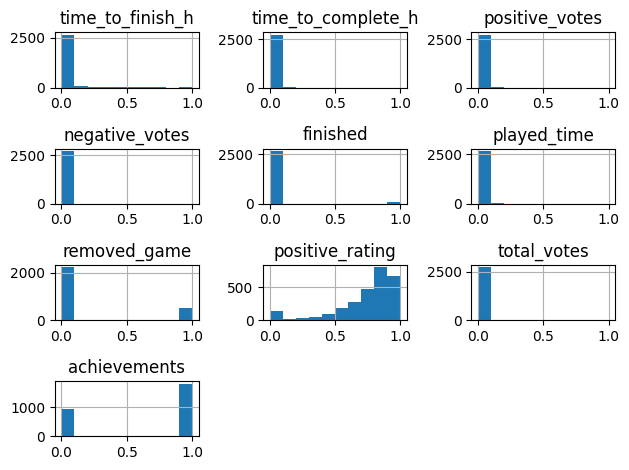

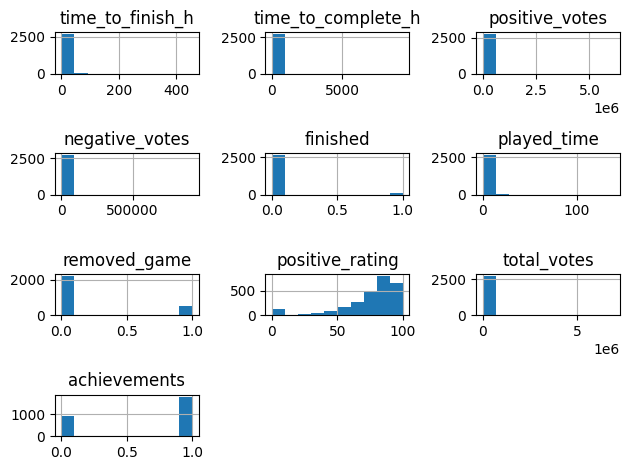

In [173]:
#Plots histogram with normalized data    
hist_norm = df_filt_copy_for_norm.hist(bins = 10)
plt.tight_layout()

#plot histogram with non-normalized data
hist = df_filt.hist(bins = 10)
plt.tight_layout()

### Distributions

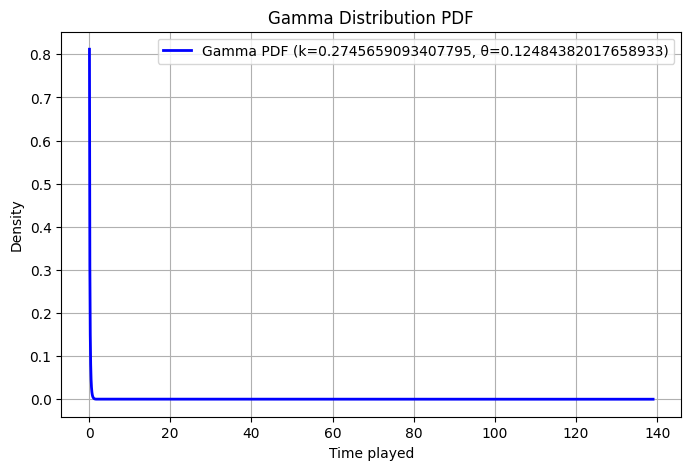

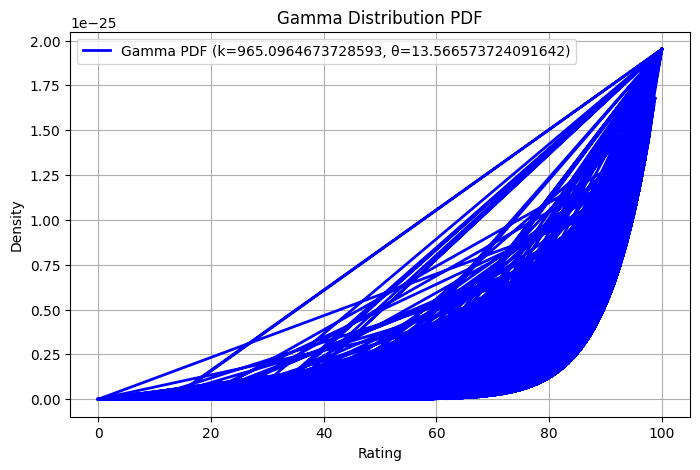

In [174]:
played_time_avg = df["played_time"].sum()/3173
rating_avg = df["positive_rating"].sum()/3173
var_played = np.var(df["played_time"])
var_rating = np.var(df["positive_rating"])
lam_played = played_time_avg**2 / var_played
lam_rating = rating_avg**2 / var_rating


#played time plot
k_played = played_time_avg * lam_played
x = df["played_time"]
pdf = scipy.stats.gamma.pdf(x, a = lam_played, scale = k_played)
plt.figure(figsize=(8, 5))
plt.plot(x, pdf, 'b-', lw=2, label=f'Gamma PDF (k={k_played}, θ={lam_played})')
plt.title('Gamma Distribution PDF')
plt.xlabel('Time played')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

#rating plot
#I think something is wrong with this but not sure
k_rating = rating_avg * lam_rating
y = df["positive_rating"]
pdf2 = scipy.stats.gamma.pdf(y, a = lam_rating, scale = k_rating)
plt.figure(figsize=(8, 5))
plt.plot(y, pdf2, 'b-', lw=2, label=f'Gamma PDF (k={k_rating}, θ={lam_rating})')
plt.title('Gamma Distribution PDF')
plt.xlabel('Rating')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()
#data = np.random.poisson(lam=317, size=3173)
#sns.histplot(data, kde=True)
#plt.title("Poisson Distribution Visualization")
#plt.xlabel("Number of Events")
#plt.ylabel("Frequency")
#plt.show()

Box-Whisker Plots

C:\Users\chris\AppData\Local\Temp\ipykernel_41696\1388854760.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_filt_boxplot.columns, rotation=45, ha='right')


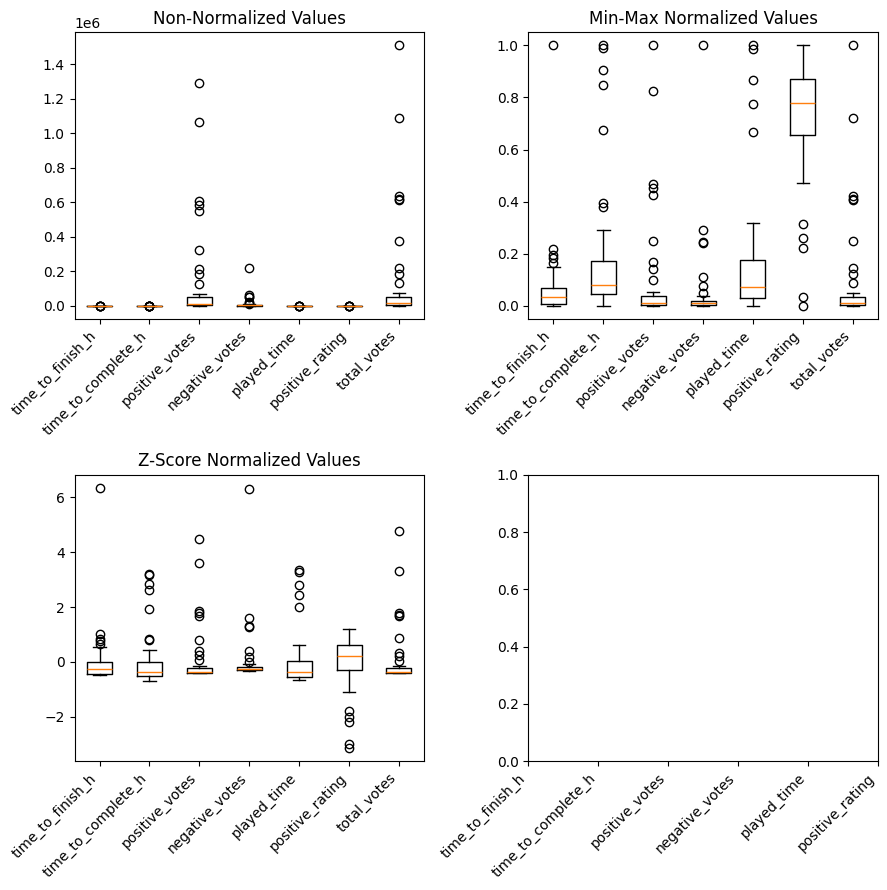

In [175]:
df_filt_boxplot = df_filt.filter(items=['time_to_finish_h', 'time_to_complete_h',
                                      'positive_votes', 'negative_votes', 'played_time',
                                      'positive_rating', 'total_votes'])
df_filt_boxplot_time_to = df_filt.filter(items = ['time_to_finish_h', 'time_to_complete_h'])
df_filt_boxplot = snip_low(df_filt_boxplot,10) # clip the 0 values causing bias
df_filt_boxplot_normalized_minmax = normalize_minmax(df_filt_boxplot,0,1)
df_filt_boxplot_normalized_zscore = normalize_zscore(df_filt_boxplot)


fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(9, 9))


#Plots boxplot with non-normalized data (not useful)
axs[0][0].boxplot(df_filt_boxplot)
axs[0][0].set_title("Non-Normalized Values")


#Plots boxplot with min-max normalized data
axs[0][1].boxplot(df_filt_boxplot_normalized_minmax)
axs[0][1].set_title("Min-Max Normalized Values")

#Plots boxplot with z-score normalized data
axs[1][0].boxplot(df_filt_boxplot_normalized_zscore)
axs[1][0].set_title("Z-Score Normalized Values")

#Format graphs
for subaxs in axs:
    for ax in subaxs:
        ax.set_xticklabels(df_filt_boxplot.columns, rotation=45, ha='right')

plt.tight_layout()


### Violin Plots

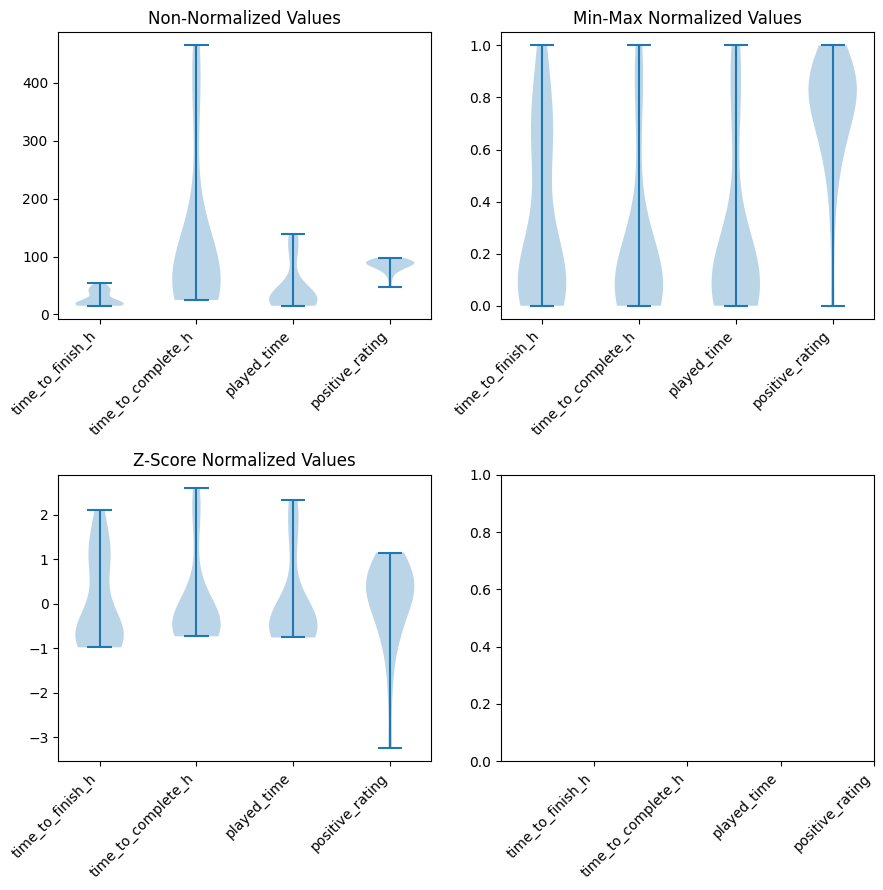

In [176]:
df_filt_violinplot = df_filt.filter(items = ['time_to_finish_h', 'time_to_complete_h', 'played_time', 'positive_rating'])
df_filt_violinplot = snip_low(df_filt_violinplot,15) # clip the 0 values causing bias
df_filt_violinplot_normalized_minmax = normalize_minmax(df_filt_violinplot,0,1)
df_filt_violinplot_normalized_zscore = normalize_zscore(df_filt_violinplot)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(9, 9))

#Plots voilinplot with non-normalized data
axs[0][0].violinplot(df_filt_violinplot)
axs[0][0].set_title("Non-Normalized Values")

#Plots voilinplot with min-max normalized data
axs[0][1].violinplot(df_filt_violinplot_normalized_minmax)
axs[0][1].set_title("Min-Max Normalized Values")

#Plots voilinplot with z-score normalized data
axs[1][0].violinplot(df_filt_violinplot_normalized_zscore)
axs[1][0].set_title("Z-Score Normalized Values")

#Format graphs 
for subaxs in axs:
    for ax in subaxs:
        ax.set_xticks([y + 1 for y in range(len(df_filt_violinplot.columns))],
              labels=df_filt_violinplot.columns,
              rotation=45, ha='right')

plt.tight_layout()

## Data Quality & Cleaning

Instruction: Add a comment for each method

<>:45: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
<>:48: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
<>:45: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
<>:48: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
C:\Users\chris\AppData\Local\Temp\ipykernel_41696\2233748448.py:45: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
  df_copy['tags'] = df_copy['tags'].str.split(',\s*')  # split by comma and optional space
C:\Users\chris\AppData\Local\Temp\ipykernel_41696\2233748448.py:48: SyntaxWarn

,name,time_to_finish_h,time_to_complete_h,genre,positive_votes,negative_votes,developer,publisher,tags,finished,played_time,release,removed_game,positive_rating,total_votes,achievements
0,Counter-Strike: Global Offensive,55,773,"[Action, Free to Play]",6121597,804720,"Valve, Hidden Path Entertainment",Valve,"[FPS, Shooter, Multiplayer, Competitive, Actio...",0,5.0,21-Aug-2012,0,88.4,6926317,1
1,Grand Theft Auto V,32,81,"[Action, Adventure]",1291158,217658,Rockstar North,Rockstar Games,"[Open World, Action, Multiplayer, Crime, Autom...",0,139.0,13-Apr-2015,0,85.6,1508816,1
2,Terraria,50,183,"[Action, Adventure, Indie, RPG]",1063429,23879,Re-Logic,Re-Logic,"[Open World Survival Craft, Sandbox, Survival,...",0,15.3,16-May-2011,0,97.8,1087308,1
3,Garry's Mod,54,595,"[Indie, Simulation]",897377,30981,Facepunch Studios,Valve,"[Sandbox, Multiplayer, Funny, Moddable, Buildi...",0,4.0,29-Nov-2006,0,96.7,928358,1
4,Rust,23,104,"[Action, Adventure, Indie, Massively Multiplay...",770797,116417,Facepunch Studios,Facepunch Studios,"[Survival, Crafting, Multiplayer, Open World, ...",0,1.8,08-Feb-2018,0,86.9,887214,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1420,GALAK-Z,10,0,"[Action, Indie]",378,138,17-BIT,17-BIT,"[Action Roguelike, Action, Indie, Space, Arcad...",0,8.1,29-Oct-2015,0,73.3,516,1
1421,Cultures - Northland,14,33,[Strategy],422,88,Funatics Software,Daedalic Entertainment,"[Strategy, City Builder, RTS, Resource Managem...",0,0.0,26-Mar-2015,0,82.7,510,0
1422,Dungeon of Zolthan,1,2,"[Action, Adventure, Indie]",392,116,Robert Alvarez,New Reality Games,"[Indie, Action, Adventure, Platformer, Metroid...",0,4.6,11-May-2016,0,77.2,508,1
1423,Anachronox,28,40,NaN,370,138,0,Square Enix,"[RPG, Cyberpunk, Sci-fi, Comedy, Classic, Turn...",0,0.0,17-Oct-2013,0,72.8,508,0


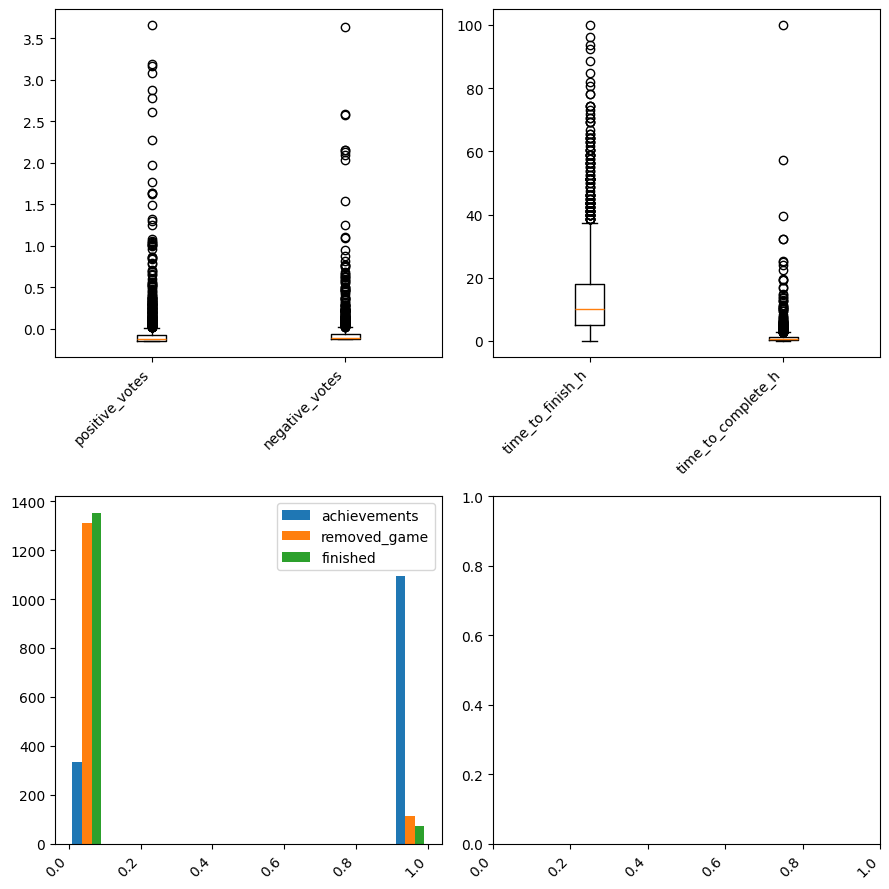

In [177]:
# Create copy for cleanup
df_copy = df.copy()
# Filter for columns we want to focus on
df_copy = df_copy.drop(["appid_steam_games", "appid_steam", "howlongtobeat", "similarity", "perfect_match", "name_steam_games_database", "name_steam_database", "minimun_requirements", "recommended_requirements"], axis=1)
# Remove bad data
df_copy = df_copy[df_copy ['time_to_finish_h']  != 'No time registered yet']
df_copy = df_copy[df_copy ['time_to_complete_h']  != 'No time registered yet']
# Fill missing values
df_copy = df_copy.fillna(0)
# Convert string values to integers
df_copy['time_to_finish_h'] = df_copy['time_to_finish_h'].apply(lambda x: int(x))
df_copy['time_to_complete_h'] = df_copy['time_to_complete_h'].apply(lambda x: int(x))
# Fill "True" placeholders with 1
df_copy = df_copy.replace('X', 1)

# Isolate the types of data values we want to focus on
df_copy = df_copy[df_copy["total_votes"] >= 500]
df_copy = df_copy[df_copy["positive_rating"] >= 70]
# Create dataframe that we can normalize by removing string columns
# df_copy_for_norm = df_copy.drop(['name', 'release', 'genre', 'tags', 'publisher', 'developer', 'achievements', 'removed_game', 'finished', 'positive_rating'], axis=1)
df_copy_for_norm = df_copy.drop(['name', 'release', 'genre', 'tags', 'publisher', 'developer', 'achievements', 'removed_game', 'finished'], axis=1)
df_copy_for_norm = Z_Score_Outlier_Removal(df_copy_for_norm, 3)
df_copy_norm_minmax = normalize_minmax(df_copy_for_norm, 0, 100)

df_copy_norm_zscore = normalize_zscore(df_copy_for_norm)


# Create a few plots so we can visualize the data metter
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(9, 9))
# axs[0][0].boxplot(df_copy_norm_zscore[["positive_votes", "negative_votes"]], labels=df_copy_norm_zscore[["positive_votes", "negative_votes"]].columns)
axs[0][0].boxplot(snip_high(df_copy_norm_zscore[["positive_votes", "negative_votes"]], 4), labels=df_copy_norm_zscore[["positive_votes", "negative_votes"]].columns)
axs[0][1].boxplot(df_copy_norm_minmax[["time_to_finish_h", "time_to_complete_h"]], labels=df_copy_norm_minmax[["time_to_finish_h", "time_to_complete_h"]].columns)
df_copy = df_copy.sort_values(by='total_votes', ascending=False)
df_copy = df_copy.reset_index(drop=True)
axs[1][0].hist(df_copy[["achievements", "removed_game", "finished"]], label=["achievements", "removed_game", "finished"])
axs[1][0].legend(prop={'size': 10})
for sax in axs:
    for ax in sax:
        for tick in ax.get_xticklabels():
            tick.set_rotation(45)
            tick.set_ha("right")
plt.tight_layout()

# Create genre and tag lists
df_copy['tags'] = df_copy['tags'].str.split(',\s*')  # split by comma and optional space
# for tags in df_copy['tags']:
#     print(tags)
df_copy['genre'] = df_copy['genre'].str.split(',\s*')  # split by comma and optional space
# for genre in df_copy['genre']:
#     print(genre)

# Output data table (53 games???)
df_copy

In [178]:
# Preparing genres and tags for analysis

def create_cat_lookup_tables(df,col):
    unique = []
    column = df[col]
    for itemidx in range(len(column)):
        item = column[itemidx]
        if isinstance(item,list):
            for thingidx in range(len(item)):
                thing = item[thingidx]
                if thing not in unique:
                    unique.append(thing)
    print(f"Unique {col}:\t",unique)

    lookuptable = pd.DataFrame(index=[0],columns=unique)
    lookuptable = lookuptable.fillna("")


    for idx,thing in enumerate(unique):
        for itemidx in range(len(column)):
            item = column[itemidx]
            if isinstance(item,list) and thing in item:
                if lookuptable.at[0,thing]: lookuptable.at[0,thing] = lookuptable.at[0,thing] + ","
                lookuptable.at[0,thing] = lookuptable.at[0,thing]+str(itemidx)

    for each in lookuptable:
        lookuptable[each] = lookuptable[each].str.split(',')  # split by comma

    countstable = lookuptable.copy()
    for each in countstable:
        countstable[each] = len(countstable[each][0])

    return unique,lookuptable.transpose(),countstable.transpose().sort_values(by=[0],ascending=False)

genreunique, genrelookuptable, genrecountstable = create_cat_lookup_tables(df_copy,"genre")
tagunique, taglookuptable, tagcountstable = create_cat_lookup_tables(df_copy,"tags")

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(genrelookuptable.transpose())
    display(genrecountstable.transpose())
    display(taglookuptable.transpose())
    display(tagcountstable.transpose())

Unique genre:	 ['Action', 'Free to Play', 'Adventure', 'Indie', 'RPG', 'Simulation', 'Massively Multiplayer', 'Casual', 'Racing', 'Sports', 'Strategy', 'Early Access', 'Violent', 'Gore']
Unique tags:	 ['FPS', 'Shooter', 'Multiplayer', 'Competitive', 'Action', 'Team-Based', 'e-sports', 'Tactical', 'First-Person', 'PvP', 'Online Co-Op', 'Co-op', 'Strategy', 'Military', 'War', 'Difficult', 'Trading', 'Realistic', 'Fast-Paced', 'Moddable', 'Open World', 'Crime', 'Automobile Sim', 'Third Person', 'Mature', 'Adventure', 'Singleplayer', 'Third-Person Shooter', 'Racing', 'Atmospheric', 'Sandbox', 'Funny', 'Great Soundtrack', 'Comedy', 'Open World Survival Craft', 'Survival', '2D', 'Pixel Graphics', 'Crafting', 'Building', 'Exploration', 'Indie', 'RPG', 'Replay Value', 'Platformer', 'Mod', 'Physics', 'Simulation', 'Animation & Modeling', 'Massively Multiplayer', 'Nudity', 'Early Access', 'Post-apocalyptic', 'Zombies', 'Horror', 'Gore', 'Survival Horror', 'Local Co-Op', 'Social Deduction', 'Spac

,Action,Free to Play,Adventure,Indie,RPG,Simulation,Massively Multiplayer,Casual,Racing,Sports,Strategy,Early Access,Violent,Gore
0,"[0, 1, 2, 4, 5, 7, 8, 10, 11, 12, 13, 15, 16, ...","[0, 12, 15, 22, 37, 38, 57, 75, 81, 102, 117, ...","[1, 2, 4, 11, 12, 17, 21, 24, 27, 31, 37, 40, ...","[2, 3, 4, 9, 11, 13, 14, 16, 17, 22, 24, 27, 2...","[2, 4, 8, 10, 11, 14, 15, 19, 23, 25, 27, 28, ...","[3, 9, 14, 17, 27, 30, 32, 40, 57, 60, 62, 63,...","[4, 11, 16, 37, 49, 57, 79, 111, 179, 186, 317...","[6, 16, 38, 39, 40, 71, 81, 104, 113, 121, 134...","[13, 42, 86, 132, 173, 189, 214, 220, 283, 287...","[13, 16, 62, 86, 95, 173, 177, 189, 198, 220, ...","[26, 27, 30, 32, 36, 52, 53, 60, 68, 69, 73, 7...","[27, 282, 786]",[480],[658]


,Action,Indie,Adventure,RPG,Strategy,Casual,Simulation,Racing,Sports,Free to Play,Massively Multiplayer,Early Access,Violent,Gore
0,814,712,571,289,236,233,182,68,59,36,12,3,1,1


,FPS,Shooter,Multiplayer,Competitive,Action,Team-Based,e-sports,Tactical,First-Person,PvP,Online Co-Op,Co-op,Strategy,Military,War,Difficult,Trading,Realistic,Fast-Paced,Moddable,Open World,Crime,Automobile Sim,Third Person,Mature,Adventure,Singleplayer,Third-Person Shooter,Racing,Atmospheric,Sandbox,Funny,Great Soundtrack,Comedy,Open World Survival Craft,Survival,2D,Pixel Graphics,Crafting,Building,Exploration,Indie,RPG,Replay Value,Platformer,Mod,Physics,Simulation,Animation & Modeling,Massively Multiplayer,Nudity,Early Access,Post-apocalyptic,Zombies,Horror,Gore,Survival Horror,Local Co-Op,Social Deduction,Space,Psychological,Party Game,Cartoony,Local Multiplayer,Casual,Sci-fi,Minigames,Colorful,Top-Down,Aliens,Blood,Stealth,Violent,Psychological Horror,Souls-like,Dark Fantasy,Action RPG,Fantasy,3D,Character Customization,Family Friendly,Driving,Transportation,Relaxing,Immersive Sim,Economy,Management,Controller,Heist,Looter Shooter,Gun Customization,PvE,Dinosaurs,Base-Building,Dragons,Free to Play,Battle Royale,Hero Shooter,Loot,Lore-Rich,Cyberpunk,Cinematic,Football (Soccer),Sports,Football (American),Split Screen,4 Player Local,Farming Sim,Life Sim,Agriculture,Cute,Dating Sim,Fishing,Hack and Slash,Ninja,Parkour,3D Platformer,JRPG,MMORPG,Story Rich,Puzzle,Dark Humor,Puzzle-Platformer,Female Protagonist,Action-Adventure,Level Editor,Science,Fighting,2D Fighter,2D Platformer,Medieval,Magic,Epic,Metroidvania,Hand-drawn,Multiple Endings,Side Scroller,Combat,Memes,Turn-Based Strategy,Historical,Turn-Based,Grand Strategy,4X,City Builder,Hex Grid,Voxel,Tower Defense,Procedural Generation,Classic,Remake,Walking Simulator,Music,Precision Platformer,Rhythm,Arcade,Resource Management,Modern,Real-Time with Pause,Quick-Time Events,Reboot,3D Vision,World War II,Alternate History,RTS,Diplomacy,Action Roguelike,Rogue-lite,Mythology,Rogue-like,Dungeon Crawler,Isometric,Perma Death,1990's,Old School,Score Attack,1980s,Assassin,Nostalgia,Choices Matter,Bullet Hell,Retro,Dark,Addictive,Touch-Friendly,Sexual Content,Class-Based,Visual Novel,Anime,Romance,Vampire,Western,Time Travel,Episodic,Time Manipulation,Mystery,Point & Click,LGBTQ+,Dystopian,Silent Protagonist,Futuristic,Illuminati,Robots,Mechs,Choose Your Own Adventure,Cartoon,Shoot 'Em Up,Steampunk,Beautiful,Linear,Immersive,Roguelike Deckbuilder,Card Game,Card Battler,Deckbuilding,Mouse only,Short,Satire,Swordplay,Political,Nonlinear,Education,Space Sim,Co-op Campaign,Games Workshop,Destruction,Tanks,Real-Time,Beat 'em up,Superhero,Detective,Comic Book,Emotional,Drama,2.5D,Hunting,Surreal,Experimental,FMV,Turn-Based Tactics,Combat Racing,Hentai,NSFW,Match 3,Horses,Kickstarter,Crowdfunded,Dark Comedy,Inventory Management,Psychedelic,Top-Down Shooter,Based On A Novel,3D Fighter,Well-Written,Unforgiving,Parody,Political Sim,Politics,VR,Cats,Narration,Vehicular Combat,RPGMaker,Interactive Fiction,Colony Sim,Capitalism,Cooking,Spectacle fighter,Character Action Game,Real Time Tactics,Strategy RPG,Stylized,Thriller,Tabletop,Board Game,Trading Card Game,Wargame,Philosophical,Pirates,Naval,Naval Combat,Noir,Martial Arts,America,Warhammer 40K,God Game,Outbreak Sim,Underwater,Sniper,Collectathon,Party,Soundtrack,Bullet Time,Minimalist,Cult Classic,Ambient,Narrative,Dynamic Narration,Conspiracy,Mining,Offroad,TrackIR,Supernatural,Transhumanism,Arena Shooter,Lovecraftian,Jump Scare,Werewolves,Twin Stick Shooter,Hacking,Dog,Rome,Benchmark,Time Attack,Time Management,Investigation,Gothic,Party-Based RPG,GameMaker,MOBA,Demons,Sailing,Mars,Flight,Hidden Object,Escape Room,World War I,Typing,Programming,Logic,CRPG,Turn-Based Combat,Tactical RPG,Text-Based,LEGO,Artificial Intelligence,Roguevania,Sokoban,Cold War,Abstract,Medical Sim,Intentionally Awkward Controls,Masterpiece,Vikings,Lemmings,Villain Protagonist,Creature Collector,Trains,Dungeons & Dragons,Runner,Asymmetric VR,Boxing,Documentary,Boss Rush,Motorbike,Music-Based Procedural Generation,Conversation,Automation,Gambling,Musou,Grid-Based Move

,Singleplayer,Action,Adventure,Indie,Great Soundtrack,Multiplayer,Atmospheric,Story Rich,2D,Casual,Co-op,RPG,Strategy,Funny,Puzzle,Difficult,Classic,Open World,Shooter,Third Person,Sci-fi,First-Person,Fantasy,Simulation,Comedy,Horror,Platformer,Retro,Gore,Female Protagonist,Controller,Arcade,Exploration,FPS,Pixel Graphics,Local Multiplayer,Online Co-Op,Local Co-Op,Sandbox,Cute,Survival,Point & Click,Family Friendly,Dark,Side Scroller,Hack and Slash,Stealth,Action RPG,Tactical,Short,Anime,Violent,Third-Person Shooter,Fast-Paced,Moddable,Psychological Horror,Colorful,Turn-Based,Nudity,Action-Adventure,Physics,Replay Value,Isometric,Character Customization,1990's,Zombies,Choices Matter,Survival Horror,Memes,Mature,Racing,Space,Mystery,Dark Fantasy,Relaxing,Competitive,Old School,Top-Down,Cult Classic,Post-apocalyptic,Puzzle-Platformer,Management,Sexual Content,Sports,Rogue-like,Remake,Turn-Based Strategy,Beat 'em up,PvP,Historical,War,Hand-drawn,Free to Play,RTS,Walking Simulator,Metroidvania,Cyberpunk,Dark Humor,4 Player Local,Rogue-lite,Cartoony,Surreal,Building,Fighting,Futuristic,Medieval,Parkour,Driving,Realistic,3D,Aliens,Magic,Multiple Endings,3D Platformer,JRPG,Team-Based,Split Screen,Military,Beautiful,Dungeon Crawler,Stylized,Automobile Sim,Steampunk,Shoot 'Em Up,Procedural Generation,Minimalist,Action Roguelike,Crafting,Addictive,Resource Management,Bullet Hell,2.5D,Dystopian,Level Editor,Base-Building,Robots,Cartoon,Crime,World War II,Real-Time with Pause,Early Access,Detective,Cinematic,Perma Death,Turn-Based Tactics,Touch-Friendly,Destruction,Loot,Visual Novel,3D Vision,Narration,Turn-Based Combat,Board Game,Music,Emotional,Episodic,Drama,Epic,Economy,Kickstarter,City Builder,Lovecraftian,Souls-like,Card Game,Escape Room,Assassin,Blood,Tower Defense,2D Fighter,1980s,VR,Romance,Massively Multiplayer,Psychological,2D Platformer,Gothic,Comic Book,Top-Down Shooter,Dating Sim,Nostalgia,Twin Stick Shooter,Rhythm,Immersive Sim,Combat,Hidden Object,Score Attack,Linear,Real Time Tactics,Education,Party-Based RPG,Grand Strategy,Time Travel,Tactical RPG,Interactive Fiction,PvE,Character Action Game,Tabletop,Noir,Alternate History,Quick-Time Events,Supernatural,Demons,CRPG,e-sports,Dragons,Co-op Campaign,Choose Your Own Adventure,Spectacle fighter,Satire,Mechs,Hentai,Experimental,Lore-Rich,Mouse only,LGBTQ+,Arena Shooter,Vehicular Combat,4X,Pirates,Thriller,Trading Card Game,Flight,Class-Based,Soundtrack,Swordplay,Political,Superhero,Psychedelic,Dynamic Narration,Combat Racing,Ninja,Immersive,Mythology,Parody,Vampire,Real-Time,Villain Protagonist,Illuminati,Dark Comedy,Deckbuilding,Runner,Logic,Open World Survival Craft,Bullet Time,Conspiracy,Silent Protagonist,Time Manipulation,Party Game,Time Attack,Based On A Novel,Games Workshop,Underwater,Philosophical,Strategy RPG,Politics,Cold War,Card Battler,Conversation,Precision Platformer,Inventory Management,Political Sim,NSFW,Programming,Abstract,MMORPG,Football (Soccer),Colony Sim,Collectathon,Life Sim,RPGMaker,Martial Arts,God Game,Diplomacy,Science,Hex Grid,Artificial Intelligence,Sequel,America,Hunting,Nonlinear,Dog,Party,Sniper,Warhammer 40K,Mod,Hacking,Investigation,Cooking,Automation,Typing,FMV,Football (American),Looter Shooter,Heist,Text-Based,Crowdfunded,Trains,GameMaker,Capitalism,Narrative,Vikings,Mars,World War I,Benchmark,3D Fighter,Dinosaurs,Naval,Reboot,Offroad,Western,Rome,Wargame,Clicker,Unforgiving,Time Management,Nature,LEGO,Hero Shooter,Minigames,Match 3,Jump Scare,Cats,Farming Sim,Grid-Based Movement,Baseball,Electronic Music,Tanks,Roguelike Deckbuilder,Mining,Transhumanism,Asynchronous Multiplayer,Game Development,Dungeons & Dragons,Motorbike,Voxel,Modern,Naval Combat,Agriculture,Masterpiece,MOBA,Horses,Space Sim,Pinball,Transportation,Boss Rush,Fishing,Intentionally Awkward Controls,Music-Based Procedural Generation,Mystery Dungeon,Basketball,Well-Written,Bikes,Tutorial,Golf,Traditional Roguelike,Gun Customization,Battle Royale,Trading,TrackIR,Ambient,Chess

## Handling Redundancy

### X-square Test

Power_divergenceResult(statistic=array([21949.52223046, 17107.98532404, 28316.70736294, 32339.39269269,
       21621.06692915, 15177.30998692, 28608.54097726]), pvalue=array([0., 0., 0., 0., 0., 0., 0.]))


Text(0.5, 1.0, 'Boxplot Visualization of Data')

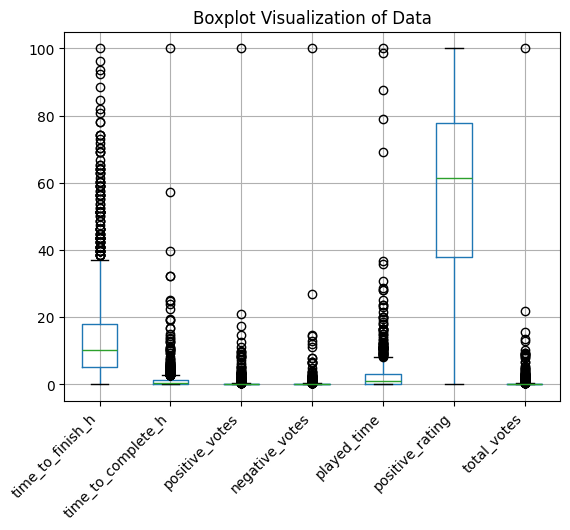

In [179]:
print(scipy.stats.chisquare(df_copy_norm_minmax))
df_copy_norm_minmax.boxplot()
plt.xticks(rotation=45, ha='right')
plt.title("Boxplot Visualization of Data")

### Correlation Analysis

In [180]:
corr = df_copy_norm_minmax.corr()
print("Pearson")
print(corr)
print("\n\n")
corr_spearman = df_copy_norm_minmax.corr(method = 'spearman')
print("Spearman")
print(corr_spearman)
#corr = df.corr(numeric_only = True, method = 'spearman')
#print(corr)

Pearson
                    time_to_finish_h  time_to_complete_h  positive_votes  \
time_to_finish_h            1.000000            0.397492        0.222819   
time_to_complete_h          0.397492            1.000000        0.241538   
positive_votes              0.222819            0.241538        1.000000   
negative_votes              0.209096            0.233491        0.961769   
played_time                 0.131841            0.074388        0.166829   
positive_rating            -0.000125            0.012628        0.080513   
total_votes                 0.222107            0.241555        0.999500   

                    negative_votes  played_time  positive_rating  total_votes  
time_to_finish_h          0.209096     0.131841        -0.000125     0.222107  
time_to_complete_h        0.233491     0.074388         0.012628     0.241555  
positive_votes            0.961769     0.166829         0.080513     0.999500  
negative_votes            1.000000     0.167265        -0.00089

### Visual Exploration (scatter-plot matrix)

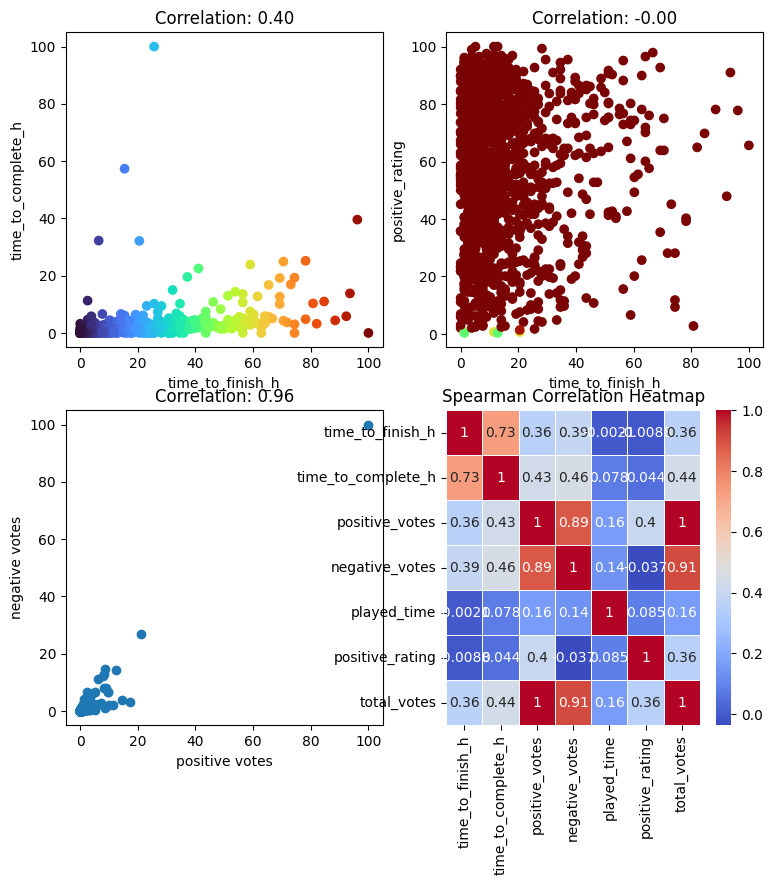

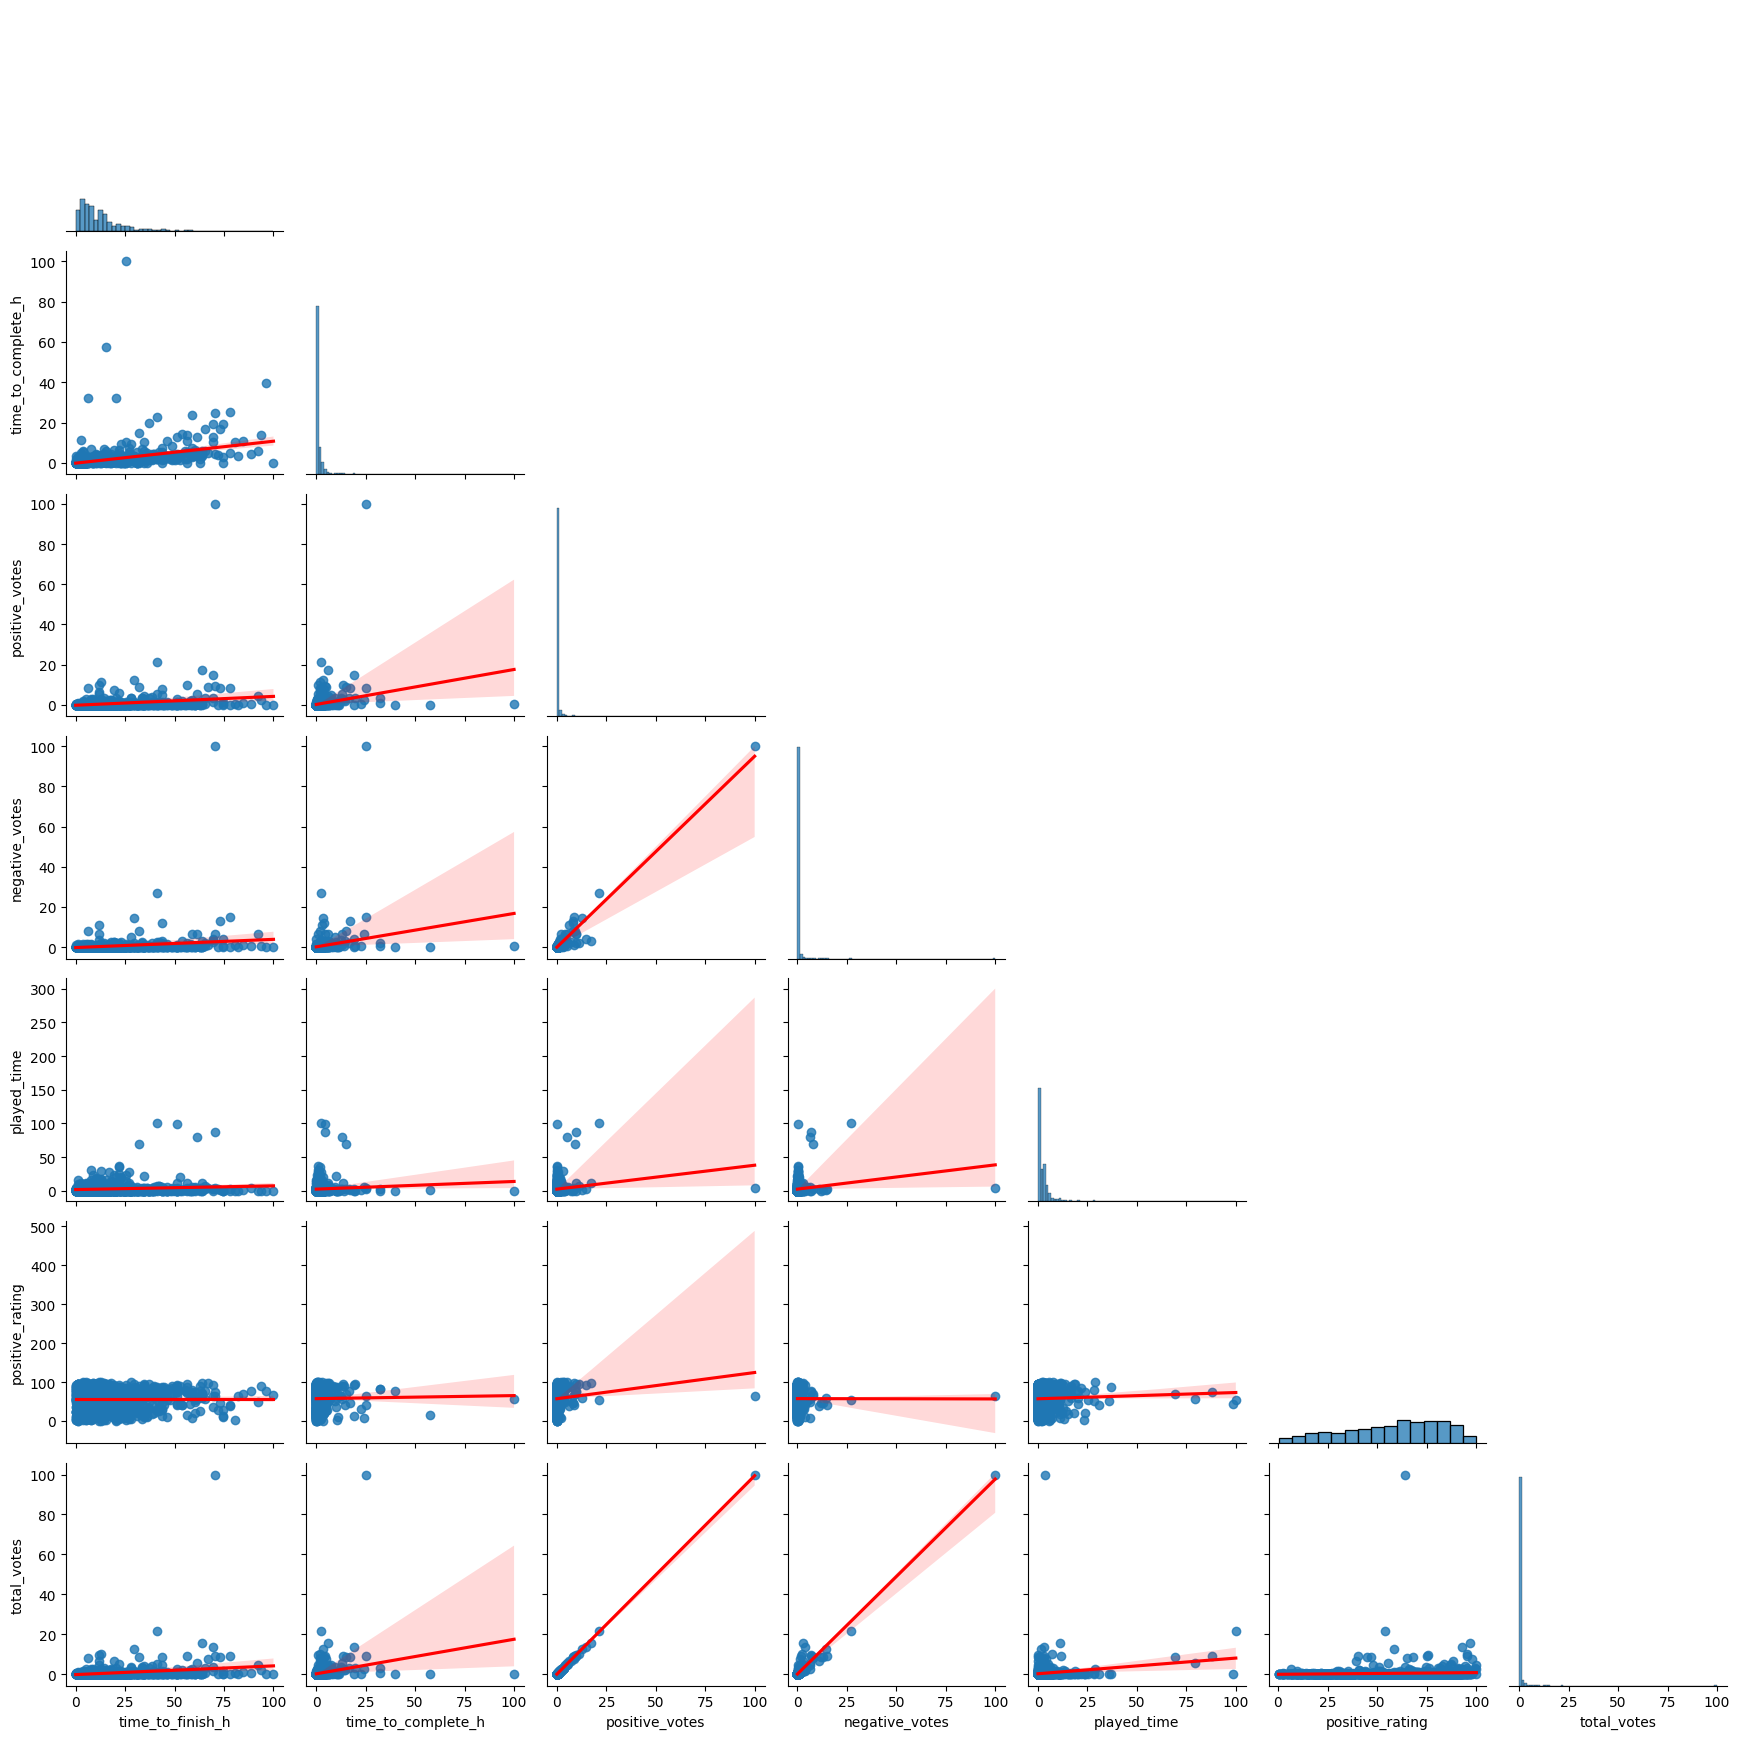

In [181]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(9, 9))
import matplotlib.colors as mcolors

axs[0][0].scatter(df_copy_norm_minmax["time_to_finish_h"], df_copy_norm_minmax["time_to_complete_h"], c=df_copy_norm_minmax["time_to_finish_h"], cmap="turbo")
axs[0][0].set_xlabel("time_to_finish_h")
axs[0][0].set_ylabel("time_to_complete_h")
axs[0][0].set_title(f'Correlation: {df_copy_norm_minmax["time_to_finish_h"].corr(df["time_to_complete_h"]):.2f}')

df_copy_norm_minmax = df_copy_norm_minmax[df_copy_norm_minmax["positive_rating"] != 0]
# Sample data
X, Y = np.meshgrid(df_copy_norm_minmax["time_to_finish_h"], df_copy_norm_minmax["positive_rating"])
Z = np.sin(X) * np.cos(Y) + 0.5 # Adding 0.5 to shift the data range


vcenter_value = 0.5

# Define the min and max values for the data range
vmin_data = Z.min()
vmax_data = Z.max()
norm = mcolors.TwoSlopeNorm(vmin=vmin_data, vcenter=vcenter_value, vmax=vmax_data)


# norm = linear, log, symlog, asinh, logit, function, functionlog
axs[0][1].scatter(df_copy_norm_minmax["time_to_finish_h"], df_copy_norm_minmax["positive_rating"], c=df_copy_norm_minmax["positive_rating"], cmap="turbo", norm=norm)
axs[0][1].set_xlabel("time_to_finish_h")
axs[0][1].set_ylabel("positive_rating")
axs[0][1].set_title(f'Correlation: {df_copy_norm_minmax["time_to_finish_h"].corr(df_copy_norm_minmax["positive_rating"]):.2f}')

#Votes plot
axs[1][0].scatter(df_copy_norm_minmax["positive_votes"], df_copy_norm_minmax["negative_votes"])
axs[1][0].set_xlabel("positive votes")
axs[1][0].set_ylabel("negative votes")
axs[1][0].set_title(f'Correlation: {df_copy_norm_minmax["positive_votes"].corr(df_copy_norm_minmax["negative_votes"]):.2f}')

#spearman heatmap
# axs[1][1].figure(figsize=(10, 8))
axs[1][1] = sns.heatmap(corr_spearman, annot=True, cmap="coolwarm", linewidths=.5)
axs[1][1].set_title("Spearman Correlation Heatmap")


def corrfunc(x, y, hue=None, ax=None, **kws):
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'Correlation = {r:.2f}', xy=(.4, .4), xycoords=ax.transAxes)


g = sns.pairplot(df_copy_norm_minmax, 
    corner=True, kind = 'reg',
    plot_kws={"line_kws": {"color": "red"}}
     )
# g.map_lower(corrfunc)
plt.tight_layout()


## Dimensionality Reduction

### PCA

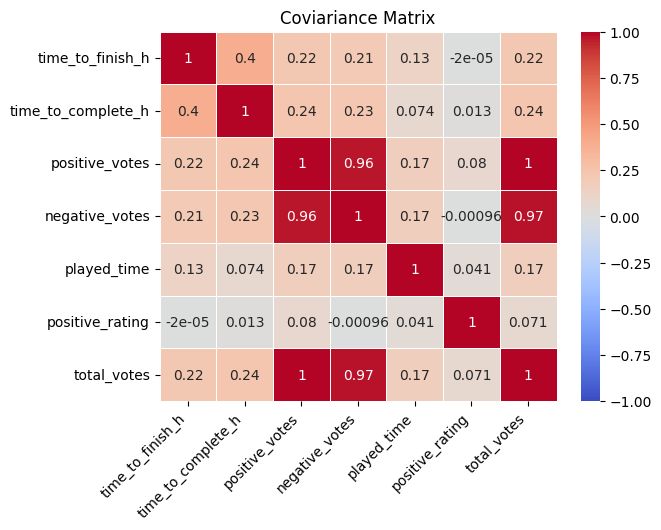

In [182]:
#Scaled Dataframe
#scaler = StandardScaler()
#scaled_data = scaler.fit_transform(df_copy_norm_minmax)
#df_std = pd.DataFrame(scaled_data, columns = df_copy_norm_minmax.columns)
#print(df_std)

#Other Scale Method, I think this one works better but idk
def std_column(column):
    mean = column.mean()
    std = column.std()
    if (std == 0):
        return 0
    return (column - mean) / std

df_stdz = df_copy_norm_minmax.apply(std_column)

#Covariance Matrix
cov_mat = df_stdz.cov()
# print(cov_mat)

#PCA, (Positive, Negative, Total Votes), (Time to Finish, Time to Complete), (Positive Rating), (Played time)
x = df_stdz.drop('positive_rating', axis=1).astype('int')
y = df_stdz['positive_rating'].astype('int')
pca = PCA(n_components=4)
x_pca = pca.fit_transform(df_stdz)
X_train, X_test, y_train, y_test = train_test_split(x_pca, y, test_size=0.3, random_state=42)
model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

# heatmap for covariance matrix
fig, ax = plt.subplots()
ax = sns.heatmap(cov_mat, vmax=1, vmin=-1, annot=True, cmap="coolwarm", linewidths=.5)
ax.set_title("Coviariance Matrix")
plt.xticks(rotation=45, ha="right")
plt.show()


## Discretization

### Histogram of Discretized Attribute

### X-square Test of Discretized Attributes

### Visual Exploration (scatter-plot matrix) of Discretized Attributes

## Feature Selection/Generation

### Select Features

### Generate Features

# Generate Clusters

## K-means

## Hierarchical

# Evaluation of Clusters

See instructions provided in the report template

## <center> REFERENCES </center>
List resources (book, internet page, etc.) that you used to complete this challenge.

https://www.geeksforgeeks.org/python/data-normalization-with-pandas/

https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.hist.html
